In [12]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

## 1. Импорты

In [13]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

## 2. Загрузка изображения

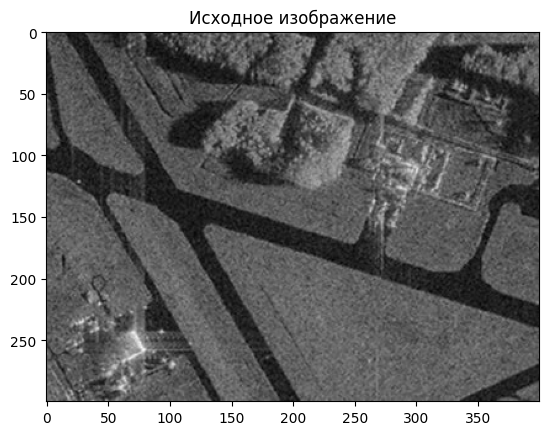

In [14]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.show()

## 3. Выделение всего участка газона

In [15]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False

In [16]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask

    return mask*255

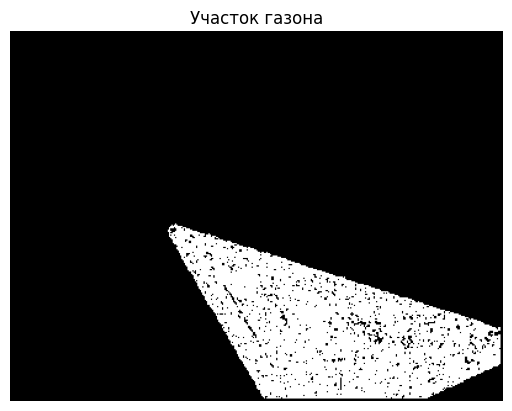

In [17]:
seed_point = (250, 250)
mask_lawn_avg = region_growing(image_gray, seed_point, homo_average, 2, 15)

plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Участок газона")
plt.axis("off")
plt.show()


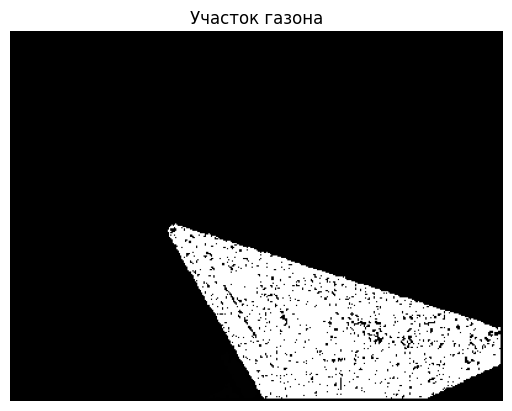

In [18]:
seed_point = (250, 250)
r = 2
T = 15

mask = region_growing(image_gray, seed_point, homo_average, r, T).astype(np.uint8)

def homo_fun(image, mask, i, j, r, T):
    # окно r вокруг (i, j)
    win_img = image[i-r:i+r+1, j-r:j+r+1]
    win_msk = mask[i-r:i+r+1, j-r:j+r+1]
    neigh = win_img[win_msk > 0]
    if neigh.size == 0:
        return False
    return abs(float(image[i, j]) - float(neigh.mean())) <= T

local_mask = mask.copy()
H, W = image_gray.shape

for i in range(r, H - r):
    for j in range(r, W - r):
        if local_mask[i, j] == 0 and local_mask[i-r:i+r+1, j-r:j+r+1].sum() > 0:
            if homo_fun(image_gray, local_mask, i, j, r, T):
                local_mask[i, j] = 1

plt.imshow(local_mask, cmap="gray")
plt.title("Участок газона")
plt.axis("off")
plt.show()


## 4. Вычисляем критерии однородности

Text(0.5, 1.0, 'K = 10')

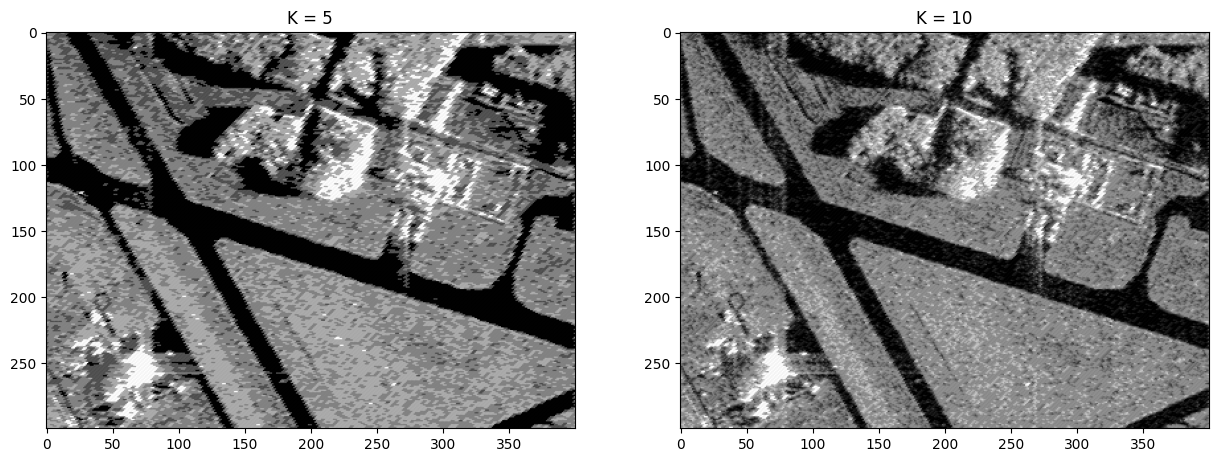

In [19]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

flags = cv2.KMEANS_RANDOM_CENTERS
z = image_gray.reshape((-1,3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
plt.imshow(res2, cmap="gray")
plt.title("K = 5")

K = 10
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.subplot(1, 2, 2)
plt.imshow(res2, cmap="gray")
plt.title("K = 10")

## 5.Алгоритм сегментации watershed+distance transform

Найдено пальм: 79


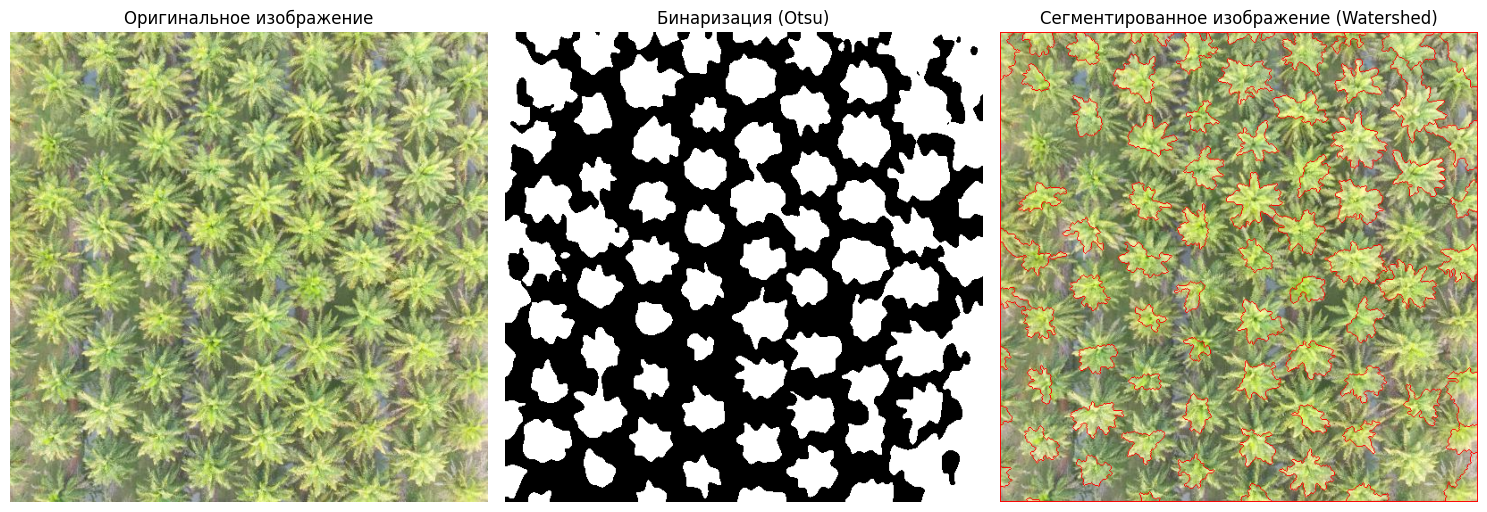

In [20]:
alpha = 0.75
r_blur = (21, 29)
bg_dilate_iter = 3
peak_merge_close = 0

image = cv2.imread("palm_1.jpg")
if image is None:
    raise FileNotFoundError("Не найден файл palm_1.jpg. Проверь, что он рядом с ноутбуком.")
rgb  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, r_blur, 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

if np.mean(thresh == 255) > 0.55:
    thresh = cv2.bitwise_not(thresh)

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

cc, n_cc = ndimage.label(thresh > 0)
sure_fg = np.zeros_like(thresh, dtype=np.uint8)

for k in range(1, n_cc + 1):
    comp = (cc == k)
    if comp.sum() < 50:
        continue
    m = dist[comp].max()
    if m <= 0:
        continue
    seeds = comp & (dist > alpha * m)
    sure_fg[seeds] = 255

if peak_merge_close > 0:
    sure_fg = cv2.morphologyEx(
        sure_fg, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=peak_merge_close
    )

kernel3 = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel3, iterations=bg_dilate_iter)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers.astype(np.int32) + 1
markers[unknown == 255] = 0

ws = cv2.watershed(image, markers)

num = int(np.sum(np.unique(ws) > 1))
print("Найдено пальм:", num)

segmented = rgb.copy()
segmented[ws == -1] = (255, 0, 0)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Оригинальное изображение")
plt.imshow(rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Бинаризация (Otsu)")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Сегментированное изображение (Watershed)")
plt.imshow(segmented)
plt.axis("off")

plt.tight_layout()
plt.show()
